In [2]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

def sampleChania(Chania, n_points, seed_val=0):
    np.random.seed(seed_val)
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

Chania = np.genfromtxt('processedChania.csv', delimiter=',')

Chania = Chania[np.where(Chania[:,2]<99)]

In [3]:
def train(trainstep, trainloss, max_iter, session, vis=False):
    plotlist = []
    delta1 = 100
    delta2 = 0
    count_iter = 0
    while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
        count_iter += 1
        delta1 = trainloss.eval(session=session)
        trainstep.run(session=session)
        delta2 = trainloss.eval(session=session)
        plotlist.append(trainloss.eval(session=session))
        
        
    if vis:
        if abs(delta1-delta2) < 0.0001:
            # print("converged in", count_iter, "steps")
            pass

        else:
            plt.plot(plotlist)
            raise ValueError()
    
    return plotlist

In [6]:
def run_GAP_automation(show=False):
    
    def vis():
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=trueusers.eval(session=sess))
        ax.set_title("True Users (Obfuscated Data)")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=np.argmax(users.eval(session=sess), axis=1))
        ax1.set_title("Predicted Users (Obfuscated Data)")
        ax1.set_xlim(-3, 3)
        ax1.set_ylim(-3, 3)
        ax1.set_zlim(-3, 3)

    PENALTY = [0]
    I = 1
    all_data = np.empty((I*len(PENALTY),3))

    for P in range(len(PENALTY)):

        for i in range(I):

            sess = tf.Session()
            keras.backend.set_session(sess)
            
            npoints = 500

            x, trueusers = sampleChania(Chania, npoints, seed_val=0)

            # p_init = keras.initializers.RandomNormal(mean=0, stddev=0.6, seed=0)
            p_init = keras.initializers.RandomUniform(minval=-1.25, maxval=1.25, seed=0)
            p1 = keras.layers.Dense(4, kernel_initializer=p_init)
            p2 = keras.layers.Dense(4, kernel_initializer=p_init)
            p3 = keras.layers.Dense(4, kernel_initializer=p_init)
            p4 = keras.layers.Dense(4, kernel_initializer=p_init)
            p5 = keras.layers.Dense(4, kernel_initializer=p_init)
            y = p5(p4(p3(p2(p1(x)))))
            p_train = tf.train.GradientDescentOptimizer(0.01) # TODO
            p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (npoints,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]
            
            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            o1 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o2 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o3 = keras.layers.Dense(4, kernel_initializer=map2_init)
            o4 = keras.layers.Dense(1, kernel_initializer=map2_init)
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (npoints,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)
            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.01)
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            privatizer_loss = tf.placeholder(tf.float32)
            map_error = tf.placeholder(tf.float32)
            penalty = tf.placeholder(tf.float32)
            threshold = tf.placeholder(tf.float32)
            x1min, x1max = np.min(x[:,2].eval(session=sess)), np.max(x[:,2].eval(session=sess))
            x2min, x2max = np.min(x[:,3].eval(session=sess)), np.max(x[:,3].eval(session=sess))
            testpoints = np.mgrid[x1min:x1max:15j, x2min:x2max:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            sess.run(tf.global_variables_initializer())
            
            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(m1_target, m1))
            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(m2_target, m2))
            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            
            penalty = tf.constant(PENALTY[P], dtype=tf.float32)
            threshold = tf.constant(0, dtype=tf.float32)     
            target_grid_rss = i4(i3(i2(i1(grid))))
            pred_grid_rss = o4(o3(o2(o1(grid))))
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(target_grid_rss, pred_grid_rss))
            zero = tf.constant(0, dtype=tf.float32)
            
            # PRIVATIZER LOSS
            # privatizer_loss = penalty*(map_error-threshold)-adversary_loss
            privatizer_loss = map_error-zero*adversary_loss

            delta1 = 1
            delta2 = 0
            count_iter = 0
            macro_map_error = []
            macro_ad_loss = []
            macro_p_loss = []
            max_iter = 10000
            
            m1_train_min = m1_train.minimize(m1_loss, var_list = m1_vars)
            m1plot = train(m1_train_min, m1_loss, 10000, sess, True)

            # while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
            while count_iter < max_iter:

                delta1 = privatizer_loss.eval(session=sess)
                m2_train_min = m2_train.minimize(m2_loss, var_list = m2_vars)
                m2plot = train(m2_train_min, m2_loss, 10000, sess, True)
                a_train_min = a_train.minimize(adversary_loss, var_list = a_vars)
                aplot = train(a_train_min, adversary_loss, 10000, sess, True)
                macro_ad_loss.append(aplot[-1])
                p_train_min = p_train.minimize(privatizer_loss, var_list = p_vars)
                pplot = train(p_train_min, privatizer_loss, 1, sess)
                macro_p_loss.extend(pplot)
                macro_map_error.append(map_error.eval(session=sess))
                delta2 = privatizer_loss.eval(session=sess)
                count_iter += 1
                
            index = int(I*P+i)
                
            if abs(delta1-delta2) < 0.0001:
                print("Privatizer converged in", count_iter, "steps")
                all_data[index] = [PENALTY[P], map_error.eval(session=sess), adversary_loss.eval(session=sess)]

                
            else:
                print("Privatizer did not converge")
                # all_data[index] = [PENALTY[P], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
                all_data[index] = [PENALTY[P], np.nan, np.nan]
            
            print("Map Error:", map_error.eval(session=sess))
            print("Adversary Error:", adversary_loss.eval(session=sess))
            
            tf.keras.backend.clear_session()
        
            if show:
                fig, ax = plt.subplots(3,1, figsize=(15,15))
                fig.subplots_adjust(hspace=0.2)
                ax[0].plot(macro_ad_loss)
                ax[0].set_title("Adversary loss")
                ax[1].plot(macro_p_loss)
                ax[1].set_title("Privatizer loss")
                ax[2].plot(macro_map_error)
                ax[2].set_title("Map Error")
                vis()
                
            elif False:
                # show at each iteration which point on the privacy utility trade we're at
                plt.scatter(macro_ad_loss, macro_map_error)
                plt.xlabel("Adversary Error")
                plt.ylabel("Map Error")
                plt.title("Privacy Utility")
    
    return all_data
            
gap_data = run_GAP_automation(show=True)

In [7]:
gap_data

In [119]:
GAP_data = gap_data
# GAP_data = np.append(GAP_data, gap_data[:-1], axis=0)

In [8]:
GAP_data

In [121]:
# GAP_data = GAP_data[np.where(GAP_data[:,0]!=0)]

Text(0.5, 1.0, 'Privacy Utility Trade: GAP Privatizer, Worst Case Adversary')

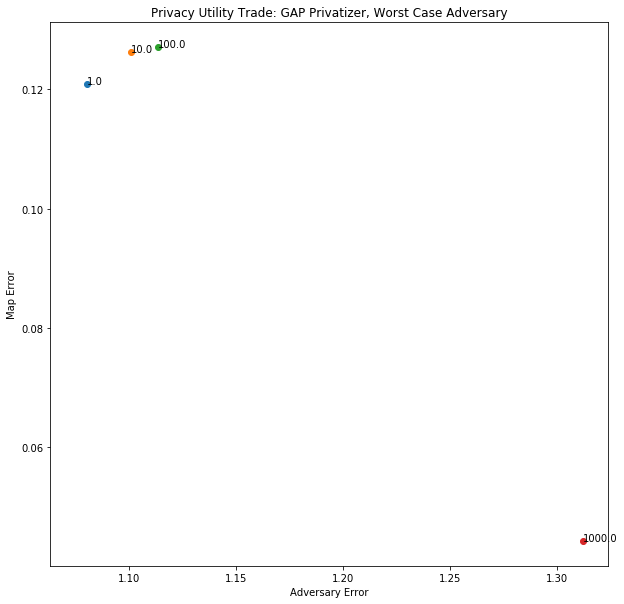

In [122]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(GAP_data[:,0]):
    indices = np.where(GAP_data[:,0]==i)
    plt.scatter(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]))
    plt.text(np.mean(GAP_data[indices][:,2]), np.mean(GAP_data[indices][:,1]), str(GAP_data[indices][0][0]))
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: GAP Privatizer, Worst Case Adversary")

In [174]:
def run_SIMPLE_automation(show=False):
    
    def vis():
    
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], x.eval(session=sess)[:,1], c=x.eval(session=sess)[:,1])
        ax.set_title("True Received Signal Strengths")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=y.eval(session=sess)[:,1])
        ax1.set_title("Obfuscated Received Signal Strengths")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)
        
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax1 = fig.add_subplot(122, projection='3d')

        ax.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=trueusers.eval(session=sess))
        ax.set_title("True Users (Obfuscated Data)")
        ax.set_xlim(-3, 1)
        ax.set_ylim(-2, 1.5)
        ax.set_zlim(-3.5, 2.5)

        ax1.scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], y.eval(session=sess)[:,1], c=np.argmax(users.eval(session=sess), axis=1))
        ax1.set_title("Predicted Users (Obfuscated Data)")
        ax1.set_xlim(-3, 1)
        ax1.set_ylim(-2, 1.5)
        ax1.set_zlim(-3.5, 2.5)

    NOISE = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1.0]
    I = 1
    all_data = np.empty((I*len(NOISE),3))

    for N in range(len(NOISE)):

        for i in range(I):

            sess = tf.Session()
            keras.backend.set_session(sess)
            
            npoints = 500 #100
            x, trueusers = sampleChania(Chania, npoints, seed_val=0)

            yarray = x.eval(session=sess) + np.random.normal(scale=NOISE[N], size=(npoints,4))
            y = tf.constant(yarray, tf.float32)

            map1_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            i1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            i4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m1 = i4(i3(i2(i1(x[:,2:]))))
            m1_target = tf.keras.backend.reshape(x[:,1], (npoints,1))
            m1_train = tf.train.GradientDescentOptimizer(0.01)
            m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]
            
            map2_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=1)
            o1 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o2 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o3 = keras.layers.Dense(4, kernel_initializer=map1_init)
            o4 = keras.layers.Dense(1, kernel_initializer=map1_init)
            m2 = o4(o3(o2(o1(y[:,2:]))))
            m2_target = tf.keras.backend.reshape(y[:,1], (npoints,1))
            m2_train = tf.train.GradientDescentOptimizer(0.01)
            m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

            a_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=3)
            a1 = keras.layers.Dense(7, kernel_initializer=a_init, activation=tf.nn.relu)
            a2 = keras.layers.Dense(5, kernel_initializer=a_init, activation=tf.nn.softmax)
            users = a2(a1(y))
            a_train = tf.train.GradientDescentOptimizer(0.01) # TODO
            test_a_train = tf.train.GradientDescentOptimizer(0.01) # TODO
            a_vars = [a1.variables, a2.variables]

            m1_loss = tf.placeholder(tf.float32)
            adversary_loss = tf.placeholder(tf.float32)
            map_error = tf.placeholder(tf.float32)
            x1min, x1max = np.min(x[:,2].eval(session=sess)), np.max(x[:,2].eval(session=sess))
            x2min, x2max = np.min(x[:,3].eval(session=sess)), np.max(x[:,3].eval(session=sess))
            testpoints = np.mgrid[x1min:x1max:15j, x2min:x2max:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            sess.run(tf.global_variables_initializer())
            
            m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(m1_target, m1))
            m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)
            
            m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(m2_target, m2))
            m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)
            
            adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
            a_train = a_train.minimize(adversary_loss, var_list = a_vars)
            
            target_grid_rss = i4(i3(i2(i1(grid))))
            pred_grid_rss = o4(o3(o2(o1(grid))))
            map_error = tf.reduce_mean(tf.keras.losses.mean_squared_logarithmic_error(target_grid_rss, pred_grid_rss))
            
            m1plot = train(m1_train, m1_loss, 10000, sess, True)
            m2plot = train(m2_train, m2_loss, 10000, sess, True)
            aplot = train(a_train, adversary_loss, 10000, sess, True)                
            index = int(I*N+i)
            
            print("Map Error:", map_error.eval(session=sess))
            print("Adversary Error:", adversary_loss.eval(session=sess))
            
            all_data[index] = [NOISE[N], map_error.eval(session=sess), adversary_loss.eval(session=sess)]
            tf.keras.backend.clear_session()
        
            if show:
                vis()
    
    return all_data
            
simple_data = run_SIMPLE_automation(show=False)

Map Error: 0.0
Adversary Error: 0.19591826
Map Error: 0.0009045721
Adversary Error: 0.19220099
Map Error: 0.008494275
Adversary Error: 0.20861518
Map Error: 0.021468189
Adversary Error: 0.25560006
Map Error: 0.02979669
Adversary Error: 0.31562325
Map Error: 0.035990342
Adversary Error: 0.3912942
Map Error: 0.038577303
Adversary Error: 0.48045224
Map Error: 0.040119596
Adversary Error: 0.57131606
Map Error: 0.04224966
Adversary Error: 0.6531956
Map Error: 0.04468238
Adversary Error: 0.73688626
Map Error: 0.046350475
Adversary Error: 0.8003868


In [175]:
simple_data

array([[0.00000000e+00, 0.00000000e+00, 1.95918262e-01],
       [1.00000000e-01, 9.04572080e-04, 1.92200989e-01],
       [2.00000000e-01, 8.49427469e-03, 2.08615184e-01],
       [3.00000000e-01, 2.14681886e-02, 2.55600065e-01],
       [4.00000000e-01, 2.97966897e-02, 3.15623254e-01],
       [5.00000000e-01, 3.59903425e-02, 3.91294211e-01],
       [6.00000000e-01, 3.85773033e-02, 4.80452240e-01],
       [7.00000000e-01, 4.01195958e-02, 5.71316063e-01],
       [8.00000000e-01, 4.22496609e-02, 6.53195620e-01],
       [9.00000000e-01, 4.46823798e-02, 7.36886263e-01],
       [1.00000000e+00, 4.63504754e-02, 8.00386786e-01]])

In [176]:
SIMPLE_data = simple_data
# SIMPLE_data = np.append(SIMPLE_data, simple_data, axis=0)

In [177]:
# SIMPLE_data = SIMPLE_data[np.where(SIMPLE_data[:,0]!=2.0)]

Text(0.5, 1.0, 'Privacy Utility Trade: Simple Privatizer, Worst Case Adversary')

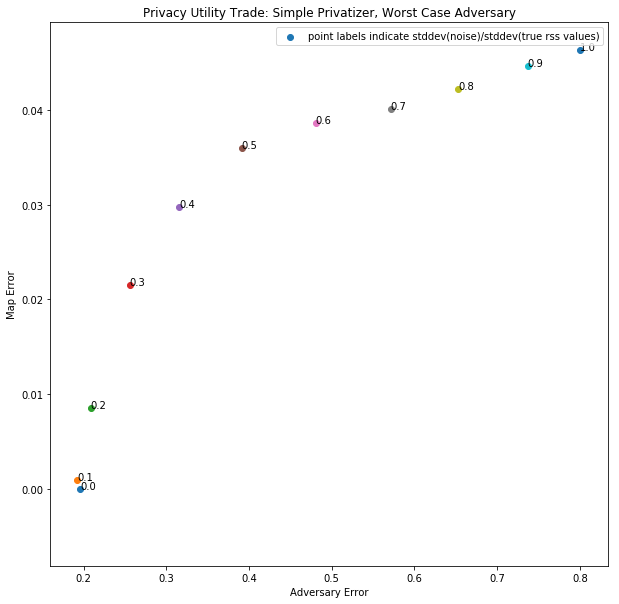

In [178]:
fig = plt.figure(figsize=(10,10))
for i in np.unique(SIMPLE_data[:,0]):
    indices = np.where(SIMPLE_data[:,0]==i)
    plt.scatter(np.mean(SIMPLE_data[indices][:,2]), np.mean(SIMPLE_data[indices][:,1]))
    plt.text(np.mean(SIMPLE_data[indices][:,2]), np.mean(SIMPLE_data[indices][:,1]), str(SIMPLE_data[indices][0][0]))
plt.legend(["point labels indicate stddev(noise)/stddev(true rss values)"], loc="best")
plt.xlabel("Adversary Error")
plt.ylabel("Map Error")
plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")